# Analysis of thermal effects

In [1]:
%load_ext autoreload
%load_ext usnm2p.skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime
import itertools

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [56]:
analysis_type = 'main'  # Analysis type
mouseline = 'line3'
layer = None  # cortical layer
slack_notify = False

### Load data

In [57]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.ROWAVG)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = [f for f in os.listdir(datadir) if f.endswith('.h5')]

# Load data from each file into a dictionary
dFF = {}
for fname in datafiles:
    dataset_ID = os.path.splitext(fname)[0]
    dFF[dataset_ID] = load_rowavg_dataset(os.path.join(datadir, fname))

# Assemble into multi-indexed pandas Series
logger.info(f'assembling {len(dFF)} datasets into single multi-indexed series')
dFF = pd.concat(dFF, axis=0, names=[Label.DATASET])
dFF

 2025/07/01 15:05:01: input data directory: /Users/tlemaire/Documents/data/usnm/rowavg/main/line3
 2025/07/01 15:05:01: loading row-average dFF data from 20191107_mouse1_region1.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20191113_mouse9_region2.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20191108_mouse6_region2.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20200313_mouse14_region1.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20191024_mouse5_region1.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20190829_mouse10_region1.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20190704_mouse3_region1.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20190707_mouse1_region1.h5
 2025/07/01 15:05:02: loading row-average dFF data from 20191112_mouse12_region1.h5
 2025/07/01 15:05:03: loading row-average dFF data from 20191109_mouse7_region1.h5
 2025/07/01 15:05:03: loading row-average dFF data from 20190807_mous

dataset                  run  trial  time (s)  
20191107_mouse1_region1  0    0      -2.804532     0.018222
                                     -2.803436     0.031979
                                     -2.802341     0.045303
                                     -2.801245     0.053098
                                     -2.800150     0.054155
                                                     ...   
20191108_mouse6_region1  14   15      25.235311   -0.002771
                                      25.236406   -0.002093
                                      25.237502    0.044416
                                      25.238597    0.029582
                                      25.239693    0.015183
Name: ΔF/F0, Length: 147456000, dtype: float64

In [8]:
# Average across trials
logger.info('averaging across trials')
trialagg_dFF = dFF.groupby([Label.DATASET, Label.RUN, Label.TIME]).mean()

 2025/07/01 14:32:12: plotting trial-averaged averaged dFF for run 7


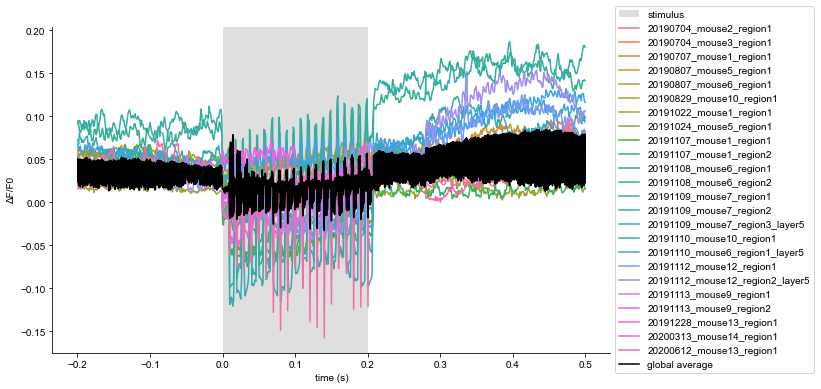

In [ ]:
# Plotting the averaged dFF for a specific run
irun = 7
tlims = (-0.2, 0.5)
logger.info(f'plotting trial-averaged averaged dFF for run {irun}')
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(ax=ax)
ax.axvspan(0, 0.2, fc='silver', alpha=0.5, label='stimulus')
for hue in [Label.DATASET, None]:
    sns.lineplot(
        data=trialagg_dFF.loc[pd.IndexSlice[:, irun, tlims[0]:tlims[1]]].reset_index(),
        x=Label.TIME,
        y=Label.DFF,
        errorbar=None,
        hue=hue,
        color='k' if hue is None else None,
        label='global average' if hue is None else None,
        ax=ax
    )
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, .5))

In [47]:
# Apply rolling window smoothing to the trial-averaged dFF data
window_size = 251
smoothed_trialagg_dFF = trialagg_dFF.groupby([Label.DATASET, Label.RUN]).transform(
    lambda s: apply_rolling_window(s.values, window_size)
)

 2025/07/01 15:17:38: plotting trial-averaged averaged dFF


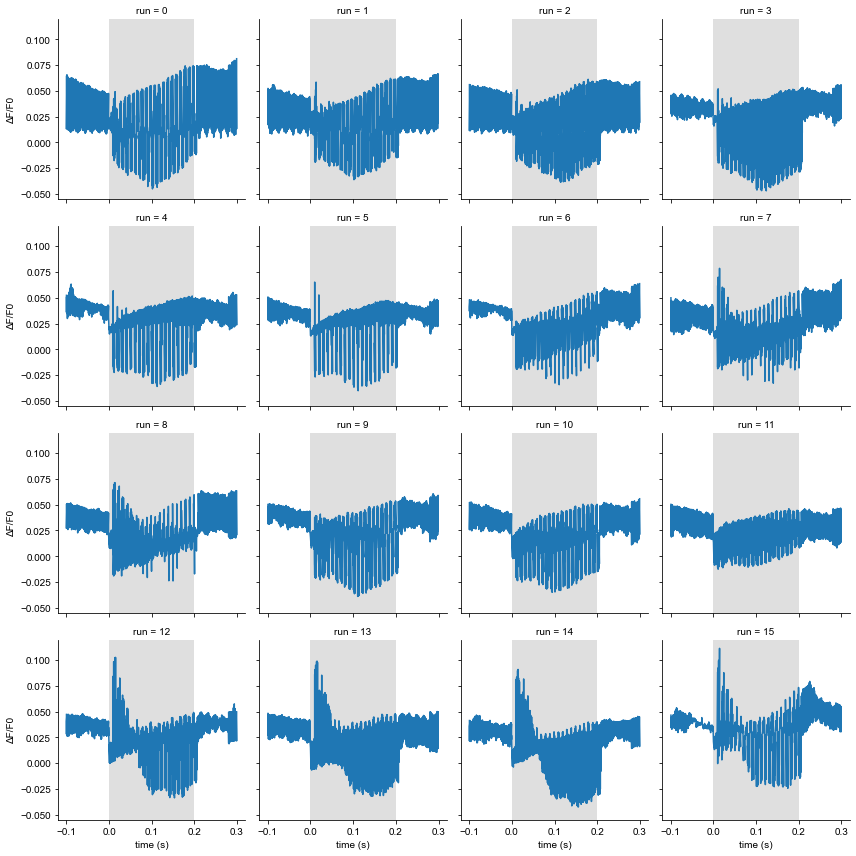

In [61]:
# Plotting the averaged dFF for a specific run
tlims = (-0.1, 0.3)
logger.info('plotting trial-averaged averaged dFF')
g = sns.relplot(
    kind='line',
    data=trialagg_dFF.loc[pd.IndexSlice[:, :, tlims[0]:tlims[1]]].reset_index(),
    x=Label.TIME,
    y=Label.DFF,
    col=Label.RUN,
    col_wrap=4,
    height=3,
    errorbar=None,
)
for ax in g.axes:
    ax.axvspan(0, 0.2, fc='silver', alpha=0.5, label='stimulus')
# sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, .5))